# Actividad en Clase Transfer Learning
**Equipo**

Andrés Alejandro Guzmán Gonzpalez - A01633819

Ernesto Reynoso Lizárraga - A01639915

Tania Sayuri Guizado Hernandez - A01640092

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/Shareddrives/Reto IA/Actividades/Actividad en Clase Transfer Learning/Dataset/train'
validation_dir = '/content/drive/Shareddrives/Reto IA/Actividades/Actividad en Clase Transfer Learning/Dataset/validation'

BATCH_SIZE = 64
IMG_SIZE = (160,160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size = IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size = IMG_SIZE)


Found 1329 files belonging to 3 classes.
Found 148 files belonging to 3 classes.


In [ ]:
class_names = train_dataset.class_names
class_names

['keyboard', 'monitor', 'mouse']

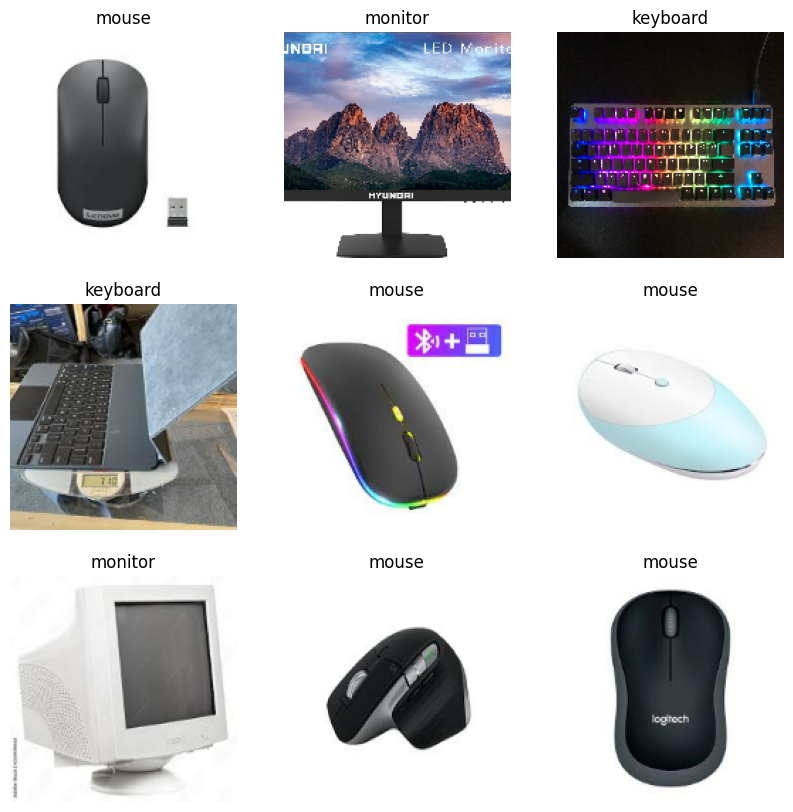

In [ ]:
plt.figure(figsize=(10,10))
for image, labels in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
val_batches =  tf.data.experimental.cardinality(validation_dataset)
test_dataset =  validation_dataset.take(val_batches // 6)
validation_dataset = validation_dataset.skip(val_batches // 6)

print('Numero de batches para validation_dataset = %d' % tf.data.experimental.cardinality(validation_dataset))
print('Numero de batches para test_dataset = %d' % tf.data.experimental.cardinality(test_dataset))

Numero de batches para validation_dataset = 3
Numero de batches para test_dataset = 0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

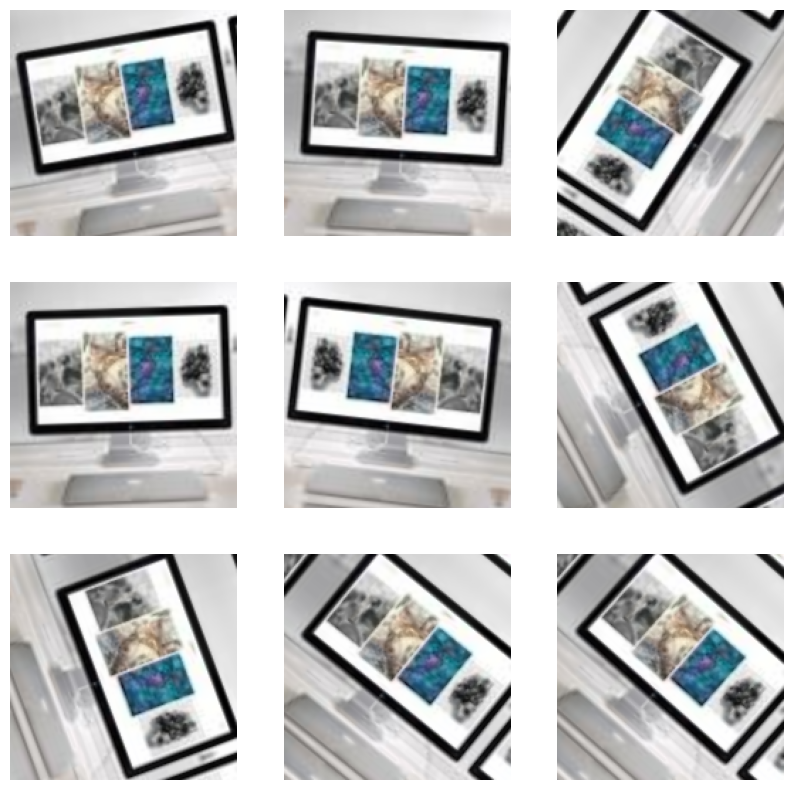

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    augmented_image= data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127,offset=1)

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
preprocessing_input = tf.keras.applications.efficientnet.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

base_model = tf.keras.applications.EfficientNetB7(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)

(160, 160, 3)


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

print(feature_batch.shape)

(64, 5, 5, 2560)


In [ ]:
base_model.trainable=False
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 rescaling_23 (Rescaling)    (None, 160, 160, 3)          0         ['input_16[0][0]']            
                                                                                                  
 normalization_7 (Normaliza  (None, 160, 160, 3)          7         ['rescaling_23[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_24 (Rescaling)    (None, 160, 160, 3)          0         ['normalization_7

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average =  global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2560)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 3)


In [ ]:
from keras.src.applications.imagenet_utils import preprocess_input
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x =  base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = prediction_layer(x)
model = tf.keras.Model(inputs,output)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem_8  (None, 160, 160, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_8 (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 efficientnetb7 (Functional  (None, 5, 5, 2560)        64097687  
 )                                                               
                                                           

In [ ]:
initial_epochs= 10

loss0,accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 14s 257ms/step - loss: 1.1371 - accuracy: 0.3446


In [ ]:
print(loss0)
print(accuracy0)

1.137115716934204
0.3445945978164673


In [ ]:
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset)

Epoch 1/10
21/21 [==============================] - 34s 468ms/step - loss: 0.7421 - accuracy: 0.7088 - val_loss: 0.5048 - val_accuracy: 0.8243
Epoch 2/10
21/21 [==============================] - 13s 475ms/step - loss: 0.4529 - accuracy: 0.8382 - val_loss: 0.4163 - val_accuracy: 0.8514
Epoch 3/10
21/21 [==============================] - 14s 528ms/step - loss: 0.3891 - accuracy: 0.8555 - val_loss: 0.3647 - val_accuracy: 0.8919
Epoch 4/10
21/21 [==============================] - 13s 489ms/step - loss: 0.3457 - accuracy: 0.8864 - val_loss: 0.3423 - val_accuracy: 0.8919
Epoch 5/10
21/21 [==============================] - 13s 508ms/step - loss: 0.3354 - accuracy: 0.8706 - val_loss: 0.3122 - val_accuracy: 0.9189
Epoch 6/10
21/21 [==============================] - 12s 483ms/step - loss: 0.3109 - accuracy: 0.8969 - val_loss: 0.3067 - val_accuracy: 0.9189
Epoch 7/10
21/21 [==============================] - 13s 514ms/step - loss: 0.2952 - accuracy: 0.8999 - val_loss: 0.3079 - val_accuracy: 0.9054

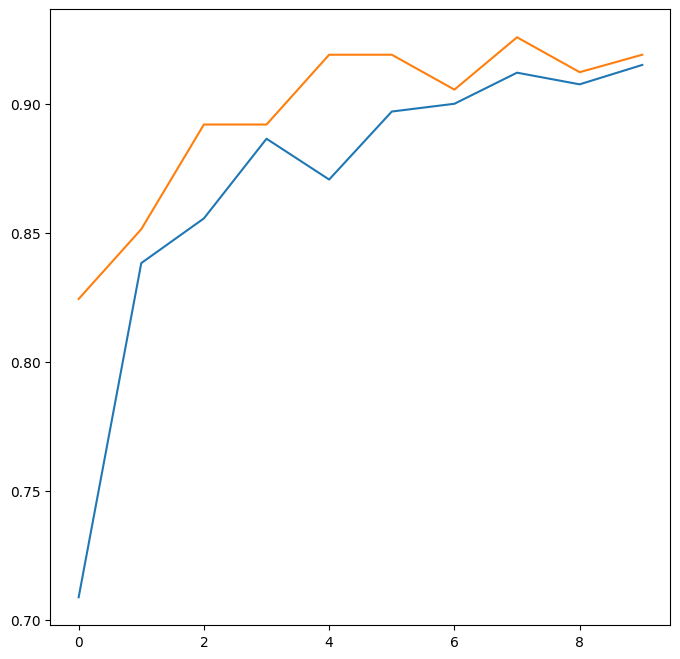

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8,8))
plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')

In [ ]:
base_model.train = True

print("Numero de capas", len(base_model.layers))

Numero de capas 814


In [ ]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem_8  (None, 160, 160, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_8 (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 efficientnetb7 (Functional  (None, 5, 5, 2560)        64097687  
 )                                                               
                                                           

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit (train_dataset,
                          epochs = total_epochs,
                          initial_epoch= history.epoch[-1],
                          validation_data = validation_dataset)

Epoch 10/20
21/21 [==============================] - 44s 767ms/step - loss: 0.2675 - accuracy: 0.9052 - val_loss: 0.2771 - val_accuracy: 0.9189
Epoch 11/20
21/21 [==============================] - 13s 502ms/step - loss: 0.2541 - accuracy: 0.9112 - val_loss: 0.2608 - val_accuracy: 0.9122
Epoch 12/20
21/21 [==============================] - 12s 490ms/step - loss: 0.2392 - accuracy: 0.9142 - val_loss: 0.2592 - val_accuracy: 0.9122
Epoch 13/20
21/21 [==============================] - 12s 493ms/step - loss: 0.2419 - accuracy: 0.9067 - val_loss: 0.2652 - val_accuracy: 0.9122
Epoch 14/20
21/21 [==============================] - 13s 500ms/step - loss: 0.2370 - accuracy: 0.9195 - val_loss: 0.2650 - val_accuracy: 0.9257
Epoch 15/20
21/21 [==============================] - 12s 482ms/step - loss: 0.2306 - accuracy: 0.9217 - val_loss: 0.2689 - val_accuracy: 0.9122
Epoch 16/20
21/21 [==============================] - 12s 472ms/step - loss: 0.2270 - accuracy: 0.9255 - val_loss: 0.2869 - val_accuracy:

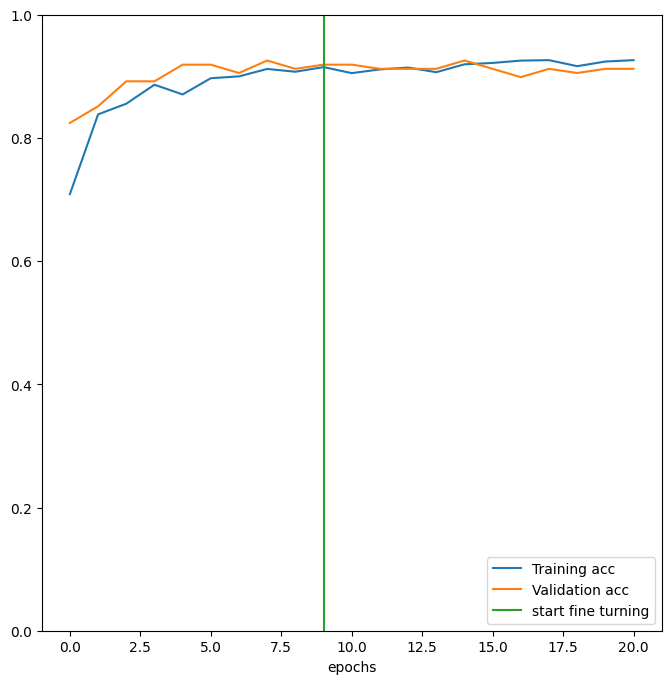

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

plt.figure(figsize=(8,8))
plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='start fine turning')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.show()

3/3 [==============================] - 2s 306ms/step


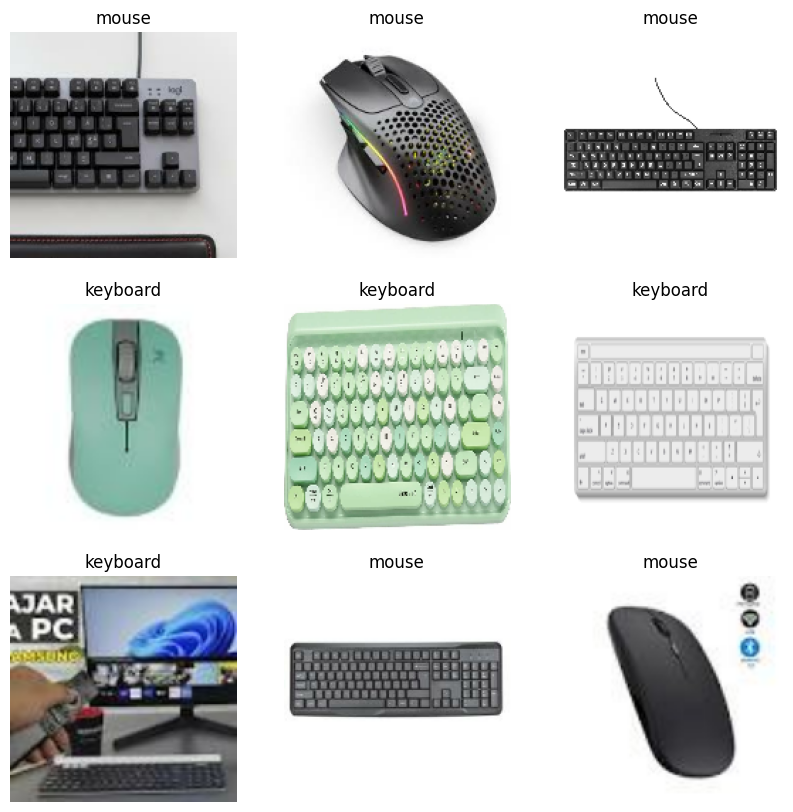

In [ ]:
predictions = model.predict(validation_dataset)

plt.figure(figsize=(10,10))
for image, labels in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis('off')